In [1]:
from daqx.util import createDevice
import time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

### General DAQ setup

In [2]:
daq = createDevice('mcc',0)
daq.config_ai(0,2)
daq.config_ao(0,1)

In [3]:
def foo(eventdata,*arg,**kwarg):
    #print('callback executed')
    if eventdata['event'] == 'samplesAcquiredFcn':
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    else:
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called with arg = {"".join(arg)}')

def collectdata(eventdata,ai,N,obj):
    print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    timept, data = ai.getdata(N)
    obj.time = np.hstack((obj.time,timept))
    obj.data = np.hstack((obj.data,data))

class daqdata:
    def __init__(self,t,d):
        self.time = t
        self.data = d
   
aidata = daqdata([],[[],[],[]])

### Set up AI

In [4]:
'''
Note - aitime generation may not be accurate at trigger freq of > 10Hz...
     - at high AI sampleRate + trigger frequency, the samplesAcquiredFcn and other processes could be dropped...
     - Need to avoid repetitive fast triggering event
'''
daq.ai.sampleRate = 100000 # Hz/channel
daq.ai.grounding = 'single-ended' #e.g. single_ended
daq.ai.iscontinuous = True # if True -> Inf
#daq.ai.trigType = 'instant'
daq.ai.trigType = 'digital-positive-edge'
daq.ai.trigRepeat = 1
#daq.ai.trigFcn = (foo,'AItrig')
#daq.ai.samplesPerTrig = 18000 # in samples/channel
daq.ai.samplesAcquiredFcnCount = 50000 # in samples/channel; 0 means no function to be called
#daq.ai.samplesAcquiredFcn = (foo,) # ',' makes it a tuple
daq.ai.samplesAcquiredFcn = lambda eventdata: collectdata(eventdata,daq.ai,daq.ai.samplesAcquiredFcnCount,aidata)
# daq.ai.samplesAcquiredFcn = None
daq.ai.startFcn = lambda eventdata: foo(eventdata,'AIstart')
daq.ai.stopFcn = lambda eventdata: foo(eventdata,'AIstop')
#daq.ai.aqMode = 'foreground' # acquisition mode
daq.ai.aqMode = 'background' # acquisition mode  

### Set up AO

In [5]:
# Parameters
F1 = 0.5  # Hz
A1 = 5.0  # +/- amplitude
offset1 = 0  # No offset
aoSR = 100000  # Hz
duration = 2 # sec
num_samples = int(aoSR * duration)

# Generate a sine wave buffer
t = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector for cycle * one period
aodata = np.zeros((2,int(aoSR * duration))) #2 channels
aodata[0,0:5] = 4 #trigger points
aodata[1,:] = A1 * np.sin(2 * np.pi * F1 * t) + offset1 #sine wave

# Plotting
# fig = plt.figure()
# plt.plot(t,aodata[0,:])
# plt.plot(t,aodata[1,:],color = 'r')
# plt.grid(True)
# fig.canvas.toolbar_position = 'top'

# Prep AO
daq.ao.sampleRate = aoSR
daq.ao.endMode = 'zero'
daq.ao.startFcn = lambda eventdata: foo(eventdata,'AOstart')
daq.ao.stopFcn = lambda eventdata: foo(eventdata,'AOstop')

daq.ao.putdata(aodata)

### Start AI,AO

In [6]:
aidata.time = []
aidata.data = [[],[],[]]
daq.ai.start()
daq.ao.start()

Tue Jan 28 23:39:40 2025: AIstartFcn called with arg = AIstart


Tue Jan 28 23:39:40 2025: AOstartFcn called with arg = AOstart
Tue Jan 28 23:39:41 2025: samplesAcquiredFcn called at 55296
Tue Jan 28 23:39:41 2025: samplesAcquiredFcn called at 115712
Tue Jan 28 23:39:42 2025: samplesAcquiredFcn called at 156672
Tue Jan 28 23:39:42 2025: samplesAcquiredFcn called at 217088
Tue Jan 28 23:39:43 2025: samplesAcquiredFcn called at 259072
Waiting for ai.getdata() to complete.
Tue Jan 28 23:39:43 2025: samplesAcquiredFcn called at 300032
Tue Jan 28 23:39:44 2025: samplesAcquiredFcn called at 360448
Tue Jan 28 23:39:44 2025: samplesAcquiredFcn called at 400384
Tue Jan 28 23:39:45 2025: samplesAcquiredFcn called at 460800
Tue Jan 28 23:39:45 2025: samplesAcquiredFcn called at 500736
Tue Jan 28 23:39:46 2025: samplesAcquiredFcn called at 561152
Tue Jan 28 23:39:46 2025: samplesAcquiredFcn called at 602112
Tue Jan 28 23:39:47 2025: samplesAcquiredFcn called at 662528
Tue Jan 28 23:39:47 2025: samplesAcquiredFcn called at 702464
Tue Jan 28 23:39:48 2025: sampl

In [7]:
daq.ai.stop()
daq.ao.stop()

Acquisition is done
Waiting for data transfer in _dataBroker to complete.
Tue Jan 28 23:39:49 2025: samplesAcquiredFcn called at 864256
win buffer freed
Tue Jan 28 23:39:49 2025: AOstopFcn called with arg = AOstop
Tue Jan 28 23:39:49 2025: AIstopFcn called with arg = AIstop


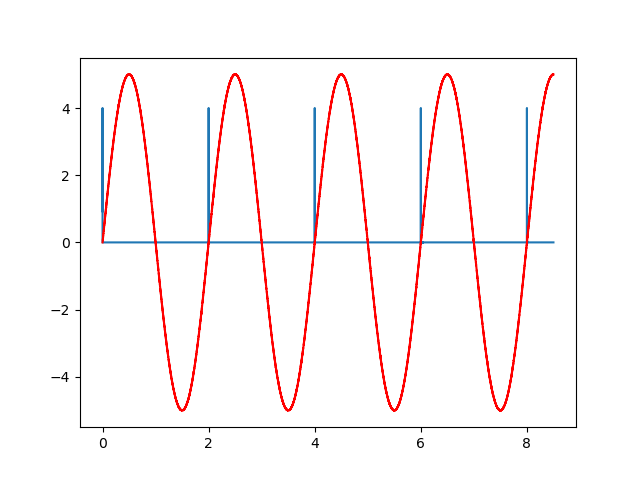

In [8]:
# print(len(daq.ai.data[0]))
# print(len(daq.ai.data[1]))
# plt.figure()
# plt.plot(daq.ai.data[0])
# plt.plot(daq.ai.data[1],'r')
#aitime, aidata = daq.ai.getdata()
plt.figure()
plt.plot(aidata.time,aidata.data[0])
plt.plot(aidata.time,aidata.data[1],'r')

In [11]:
t0 = daq.ai._trigTime[0]
trigtime = [t-t0 for t in daq.ai._trigTime]
print(trigtime)
print(aidata.data.shape)
print(aidata.time.shape)

[0.0, 0.1849355697631836, 0.36978864669799805, 0.5526852607727051, 0.7375786304473877, 0.9917707443237305, 1.176670789718628, 1.3606290817260742, 1.5445220470428467, 1.7305378913879395, 1.9925687313079834, 2.17750883102417, 2.3613874912261963, 2.5462796688079834, 2.728541851043701, 2.994462013244629, 3.178358554840088, 3.3622076511383057, 3.556151866912842, 3.7414023876190186, 3.9944510459899902, 4.178430557250977, 4.3624162673950195, 4.547308444976807, 4.734316349029541, 4.9956769943237305, 5.180742025375366, 5.363783597946167, 5.55967116355896, 5.742844581604004, 5.996842384338379, 6.181778192520142, 6.36562967300415, 6.549523115158081, 6.733418941497803, 6.998385667800903, 7.182279109954834, 7.367173194885254, 7.5501627922058105, 7.734172105789185, 7.998292446136475, 8.183300495147705, 8.368192672729492, 8.56213903427124, 8.746665954589844, 9.000680208206177, 9.205929279327393, 9.398918867111206, 9.583916902542114, 9.766872644424438, 9.991740226745605, 10.205987930297852, 10.3908240

In [ ]:
plt.figure()
plt.plot(aidata.time)

In [20]:
plt.close('all')

In [ ]:
a = 'inf'
a not in ['inf','Inf']